In [28]:
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
def printmd(string):
    display(Markdown(string))


In [30]:
fn = 'ArtificialPatientTreatment.csv'
events = pd.read_csv(fn)

events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])
events.head()


,patient,action,resource,datetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


In [4]:
print('{} has {} rows and {} columns.'.format(fn, events.shape[0], events.shape[1]))


ArtificialPatientTreatment.csv has 690 rows and 4 columns.


In [5]:
## Get the case start times to get the time deltas for the 'age' of each activity with respect to start
case_starts_ends = events.pivot_table(index='patient', aggfunc={'datetime': ['min', 'max']})
case_starts_ends = case_starts_ends.reset_index()
case_starts_ends.columns = ['patient', 'caseend', 'casestart']
events = events.merge(case_starts_ends, on='patient')
events['relativetime'] = events['datetime'] - events['casestart']
events.head()

,patient,action,resource,datetime,caseend,casestart,relativetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58


In [6]:
events['action'] = events['action'].apply(lambda x: x.strip())

In [7]:
delimiter = '___'

makeEventString = lambda x: delimiter.join(x)
makeEventString.__name__ = 'makeEventString'

numEvents = lambda x: len(x)
numEvents.__name__ = 'numEvents'


caselogs = events.pivot_table(index='patient', aggfunc={'action': [makeEventString, numEvents]})
caselogs = caselogs.reset_index()
caselogs.columns = ['patient', 'action_sequence', 'numactions']

events = pd.merge(events, caselogs, on='patient')
events['caselength'] = events['caseend'] - events['casestart']

events.head()


,patient,action,resource,datetime,caseend,casestart,relativetime,action_sequence,numactions,caselength
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,First consult___Blood test___Physical test___S...,6,6 days 20:49:17
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,First consult___Blood test___Physical test___S...,6,6 days 20:49:17


In [8]:
## Get day of week
events['weekday'] = events['datetime'].apply(lambda x: x.weekday())
events['date'] = events['datetime'].apply(lambda x: x.date())
events['startdate'] = events['casestart'].apply(lambda x: x.date())
events['hour'] = events['datetime'].apply(lambda x: x.time().hour)
## Get relative times in more friendly terms
events['relativetime_s'] = events['relativetime'].dt.seconds + 86400*events['relativetime'].dt.days
events['relativedays'] = events['relativetime'].dt.days



In [9]:
events.head()

,patient,action,resource,datetime,caseend,casestart,relativetime,action_sequence,numactions,caselength,weekday,date,startdate,hour,relativetime_s,relativedays
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 00:00:00,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,11,0,0
1,patient 0,Blood test,Lab,2017-01-02 12:47:33,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:07:22,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12,4042,0
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 01:13:39,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,12,4419,0
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06,2017-01-09 08:29:28,2017-01-02 11:40:11,0 days 04:40:55,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,0,2017-01-02,2017-01-02,16,16855,0
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09,2017-01-09 08:29:28,2017-01-02 11:40:11,3 days 01:42:58,First consult___Blood test___Physical test___S...,6,6 days 20:49:17,3,2017-01-05,2017-01-02,13,265378,3


# Questions

## What is the minimum number of events per case?

In [10]:
printmd('**Minimum number of events per case**: {}'.format(min(events['patient'].value_counts())))

**Minimum number of events per case**: 6

## Patient 26
* Which doctor did s/he have his/her consultation with?
* Which doctor did s/he have his/her consultation with?

In [11]:
first_doctor = events[events['datetime']==min(events[events['patient']=='patient 26']['datetime'])]['resource'].values[0]
last_doctor = events[events['datetime']==max(events[events['patient']=='patient 26']['datetime'])]['resource'].values[0]
printmd('**First doctor**: {}'.format(first_doctor))
printmd('**Last doctor**: {}'.format(last_doctor))


**First doctor**:  Dr. Bob

**Last doctor**:  Dr. Ben

## Which activity has the lowest occurrence overall in the event log?

In [12]:
printmd('**Activity with lowest occurrence**: {}'.format(events['action'].value_counts().sort_values().idxmin()))

**Activity with lowest occurrence**: Surgery

# Visualisations

In [13]:

activities = list(events['action'].unique())
markers = ['*', '+', 'h', 'o', 'x', 'D', '^', 'v']
assert(len(activities)==len(markers))


In [14]:
patients = events['patient'].unique()
selected_patients = patients[0:50]
patientX = events[events['patient'].isin(selected_patients)]



## Simple scatter plots

### Date

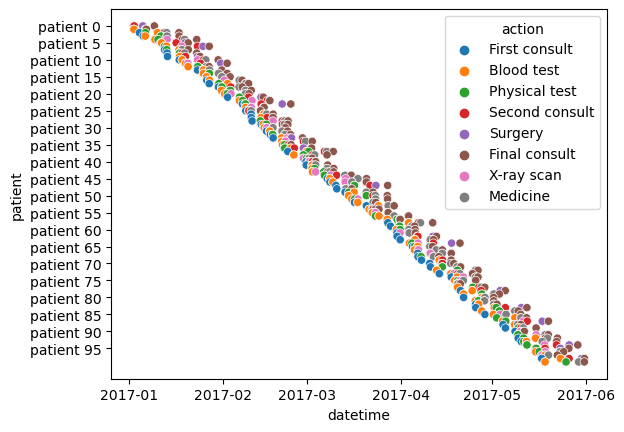

In [15]:
patientnums = [int(e) for e in events['patient'].apply(lambda x: x.strip('patient'))]
resourcenums = [i for (i, e) in enumerate(events['resource'])]

ax = sns.scatterplot(x=events['datetime'], y=events['patient'], hue=events['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));

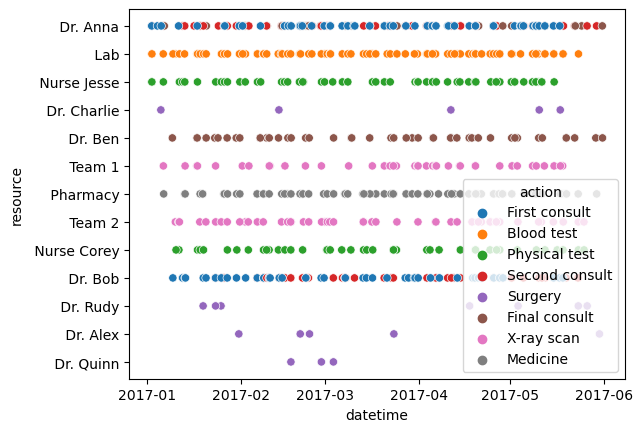

In [16]:
ax = sns.scatterplot(x=events['datetime'], y=events['resource'], hue=events['action'])

### Weekday

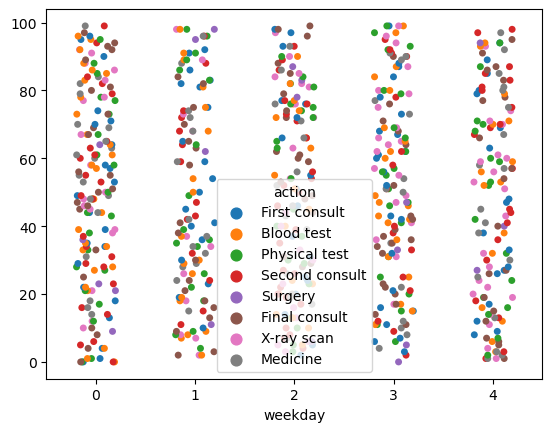

In [17]:
ax = sns.stripplot(x=events['weekday'], y=patientnums, hue=events['action'], jitter=0.2)
#plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));

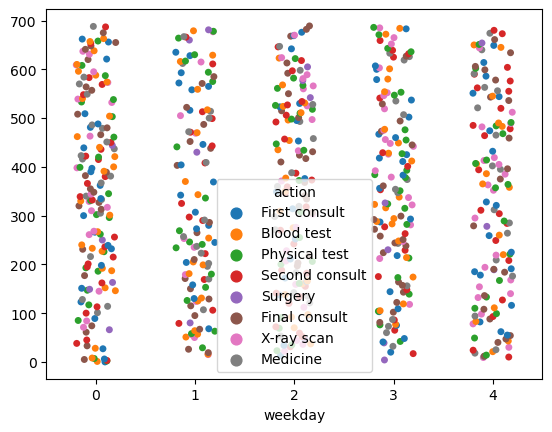

In [18]:
ax = sns.stripplot(x=events['weekday'], y=resourcenums, hue=events['action'], jitter=0.2)

### Hour

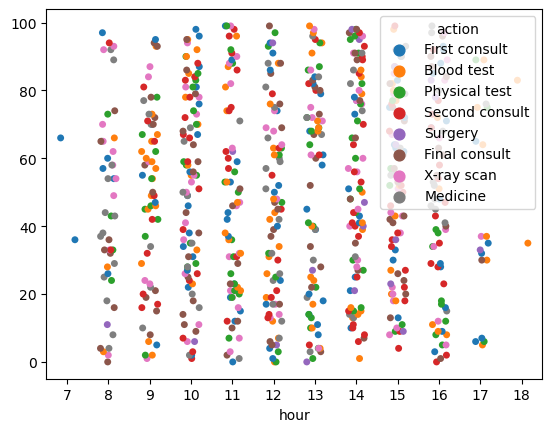

In [19]:
ax = sns.stripplot(x=events['hour'], y=patientnums, hue=events['action'], jitter=0.2)


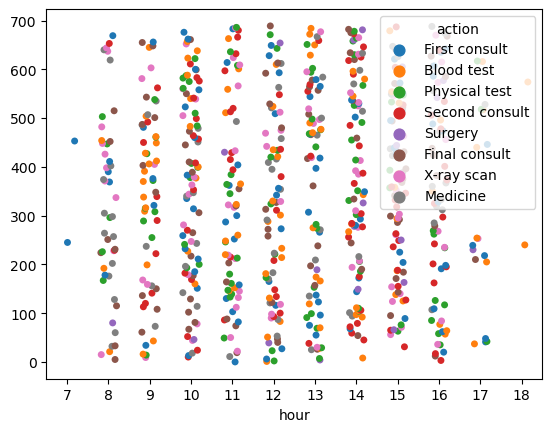

In [20]:
ax = sns.stripplot(x=events['hour'], y=resourcenums, hue=events['action'], jitter=0.2)

### Relative time 
Time since start of case

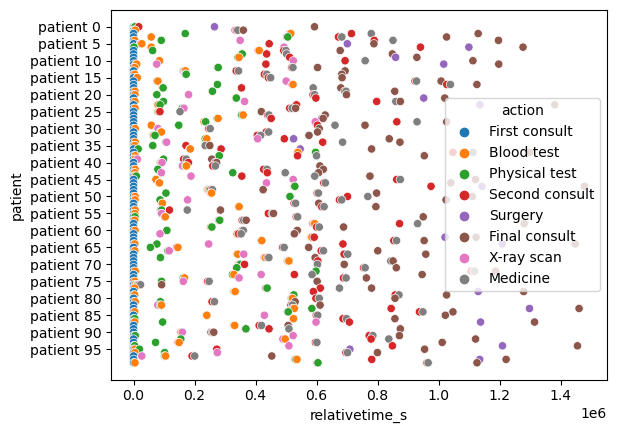

In [21]:
## Time in seconds
#ax = sns.scatterplot(x=events['relativetime'].dt.seconds, y=events['patient'], hue=events['action'])
#plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));

## Time in hours
ax = sns.scatterplot(x=events['relativetime_s'], y=events['patient'], hue=events['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));


In [22]:
ordered = events.sort_values(by=['caselength', 'patient', 'relativetime_s'])

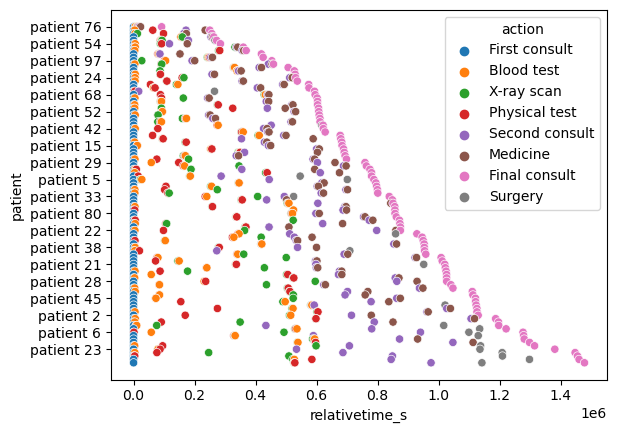

In [23]:
## Time in seconds
ax = sns.scatterplot(x=ordered['relativetime_s'], y=ordered['patient'], hue=ordered['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));
plt.show()


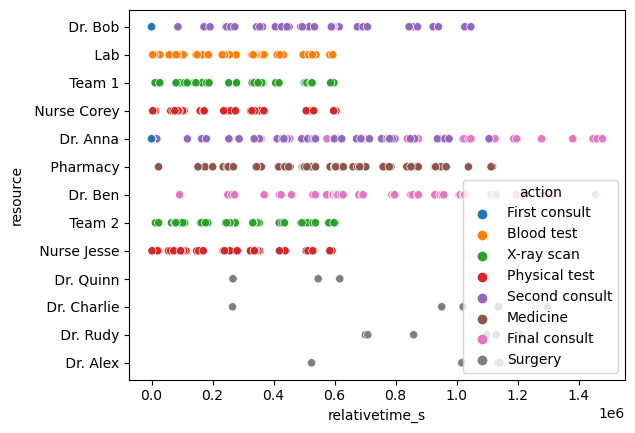

In [24]:
## Resources
ax = sns.scatterplot(x=ordered['relativetime_s'], y=ordered['resource'], hue=ordered['action'])
plt.show()


In [25]:
#pd.crosstab(events['action'], events['resource'])
pd.crosstab(events['action'], events['resource'], normalize='columns')
#pd.crosstab(events['action'], events['resource'], normalize='index')

resource,Dr. Alex,Dr. Anna,Dr. Ben,Dr. Bob,Dr. Charlie,Dr. Quinn,Dr. Rudy,Lab,Nurse Corey,Nurse Jesse,Pharmacy,Team 1,Team 2
action,,,,,,,,,,,,,
Blood test,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Final consult,0.0,0.316456,1.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
First consult,0.0,0.335443,0.0,0.51087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Medicine,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Physical test,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
Second consult,0.0,0.348101,0.0,0.48913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Surgery,1.0,0.000000,0.0,0.00000,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
X-ray scan,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


### Relative day

KeyboardInterrupt: 

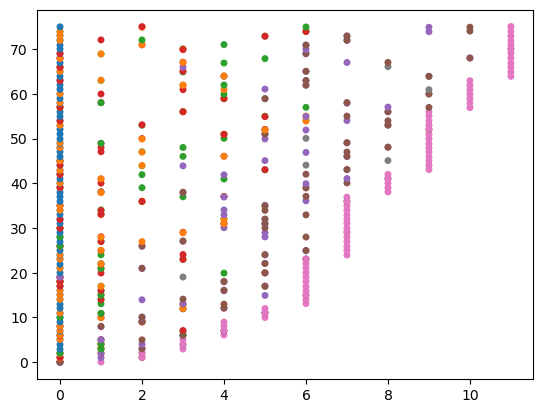

In [26]:
## Days
ax = sns.stripplot(x=ordered['relativedays'], y=ordered['patient'], hue=ordered['action'])
plt.yticks(np.arange(min(patientnums), max(patientnums)+1, 5));
plt.show()


## Discrete event plot
* y-axis represents each patient case.
* x-axis represents time since case was initiated.
* Different marker shapes represent different types of cases.

In [ ]:
## Widget libraries
from ipywidgets import widgets
from ipywidgets import interact, interact_manual

patients = events['patient'].unique()

@interact
def getCaseData(x=patients):
    return events[events['patient']==x]



In [ ]:
patientX = getCaseData(patients[10])

In [ ]:
def getEventPlot(patientlist=[patients[10], patients[21]]):
    fig, ax = plt.subplots(figsize=(20, 5))
    
    for x in patientlist:
        patientX = getCaseData(x)
        
    
        for i in range(0, len(activities)):
            a = activities[i]
            marker = markers[i]
            selected = patientX[patientX['action']==a]
            ax.plot(selected['relativetime_s'], 
                selected['patient'],
                marker=marker, markersize=11,
                alpha=0.9, color='blue', linewidth=0, 
                label=a);
    plt.show()

getEventPlot()


## Most frequent event sequence

In [ ]:
most_frequent_event = events['action_sequence'].value_counts().idxmax()


printmd('**The most frequent event (sequence) has** {} **activities.**'.format(len(most_frequent_event.split(delimiter))))
printmd('**The activity sequence is**:  {}.'.format(', '.join(most_frequent_event.split(delimiter))))

## Filtering events

### Removing events that all patients share

In [ ]:
## Visualise which events are common to patients
patient_events = pd.crosstab(events['patient'], events['action'])
sns.heatmap(patient_events, cmap="YlGnBu")

nunique = patient_events.apply(pd.Series.nunique)
shared_actions = nunique[nunique==1].index
actions_to_keep = nunique[nunique>1].index
printmd('**The following actions are common to all cases**: {}'.format(', '.join(shared_actions)))
printmd('**The following actions are the ones that we wish to keep (not common to all cases)**: {}'.format(', '.join(actions_to_keep)))


In [ ]:
#filtered = events[events['action']=='X-ray scan']
filtered = events[events['action'].isin(actions_to_keep)]
printmd('**The filtered data has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))

filtered = filtered[filtered['action']!='X-ray scan']
printmd('**The filtered data excluding X-rays has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))

filtered = filtered[~filtered['resource'].isin([' Team 1', ' Team 2'])]
printmd('**The filtered data excluding team 1 and team 2 has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))

patient_events = pd.crosstab(filtered['patient'], filtered['action'])
#sns.heatmap(patient_events, cmap="YlGnBu")

In [ ]:
printmd('**The filtered data has** {} **rows and** {} **columns.**'.format(filtered.shape[0], filtered.shape[1]))
printmd('**This amounts to** {} **cases with** {} **distinct actions.**'.format(patient_events.shape[0], patient_events.shape[1]))
printmd('**There are** {} **events.**'.format(np.sum(np.array(patient_events))))

## Process Mining
* Check out this [introduction to process mining in Python](https://towardsdatascience.com/introduction-to-process-mining-5f4ce985b7e5).
* [Documentation for pm4py](https://pm4py.fit.fraunhofer.de/)

In [ ]:
eventlog = events.copy()
### Specify which columns correspond to case (case:concept:name), 
###event (concept:name) and timestamp (time:timestamp) - rename columns in accordance
###with pm4py

eventlog.rename(columns={'datetime': 'time:timestamp', 'patient': 'case:concept:name', 'action': 'concept:name', 'resource': 'org:resource'}, inplace=True)

## Convert to log format
log = log_converter.apply(eventlog)

eventlog.head()

,case:concept:name,concept:name,org:resource,time:timestamp
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


### Alpha miner

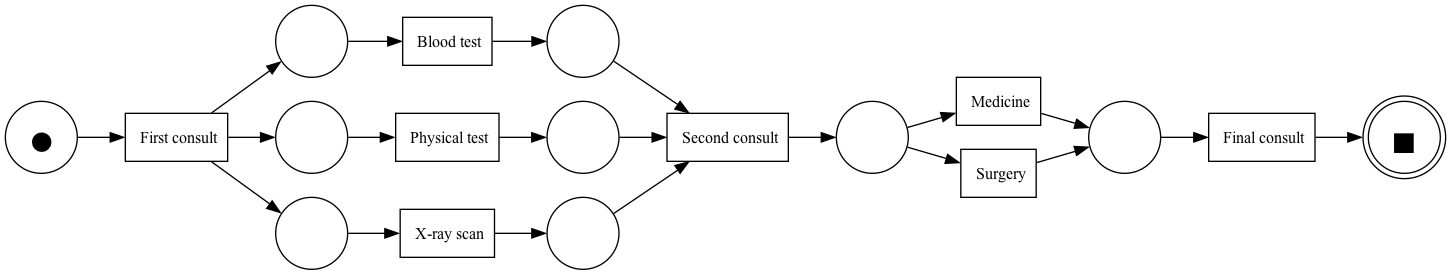

In [ ]:
# alpha miner
net, initial_marking, final_marking = alpha_miner.apply(log)

# Visualise
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

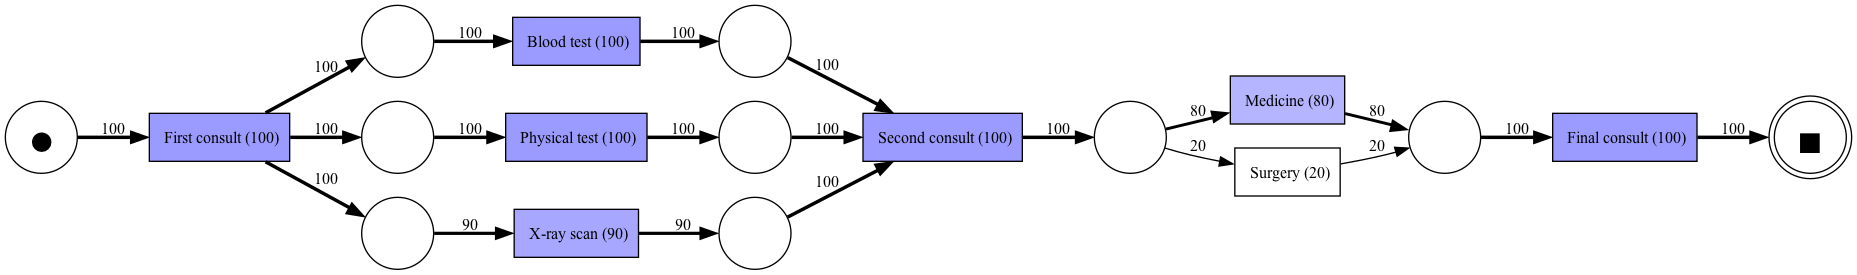

In [ ]:
# add information about frequency to the viz 
# parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                        #    parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# save the Petri net
# pn_visualizer.save(gviz, "alpha_miner_healthcare_petri_net.png")
pn_visualizer.view(gviz)

### Directly-follows graph

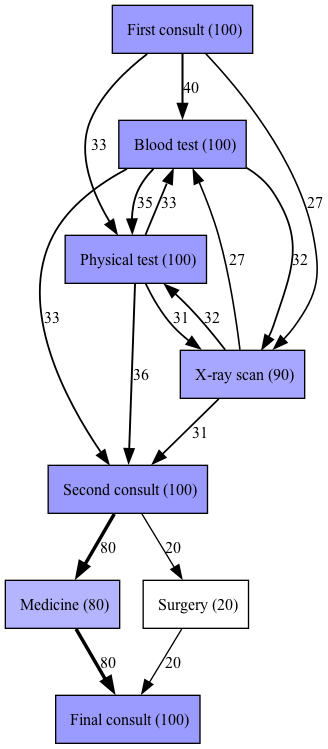

In [ ]:
#Create graph from log
dfg = dfg_discovery.apply(log)

# viz
gviz = dfg_visualizer.apply(dfg, log=log, variant=dfg_visualizer.Variants.FREQUENCY)
dfg_visualizer.view(gviz)

With average times between nodes (performance)

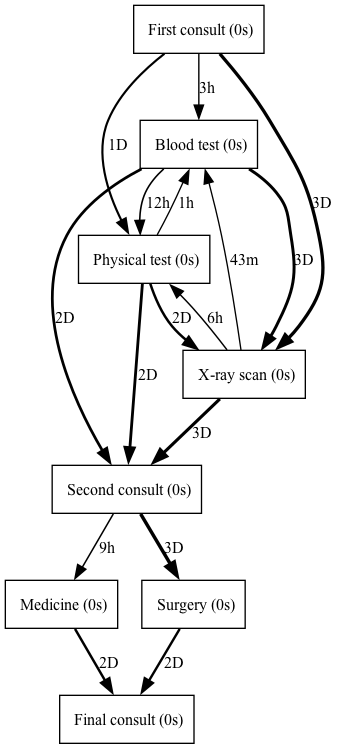

In [ ]:
# creatig the graph from log
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)

# viz
gviz = dfg_visualizer.apply(dfg, log=log, variant=dfg_visualizer.Variants.PERFORMANCE)
dfg_visualizer.view(gviz)

### Heuristic miner

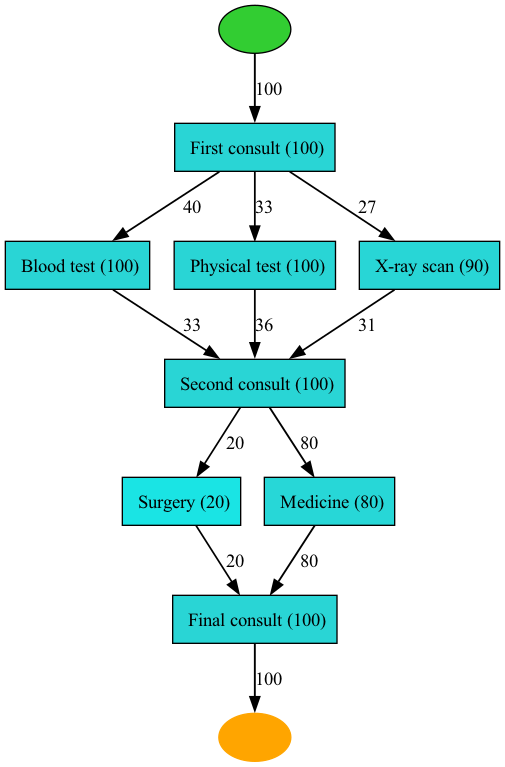

In [ ]:
# heuristics miner
heu_net = heuristics_miner.apply_heu(log)

# viz
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

Petri-net of heuristic miner output

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

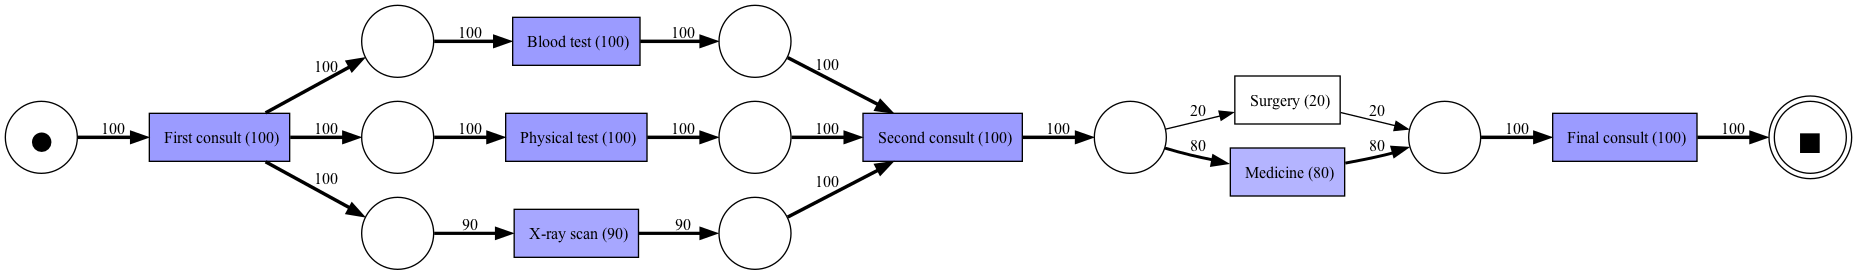

In [ ]:
# heuristics miner
net, im, fm = heuristics_miner.apply(log)

# viz
# gviz = pn_visualizer.apply(net, im, fm)
gviz = pn_visualizer.apply(net, im, fm, 
                        #    parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)
pn_visualizer.view(gviz)

### Inductive miner

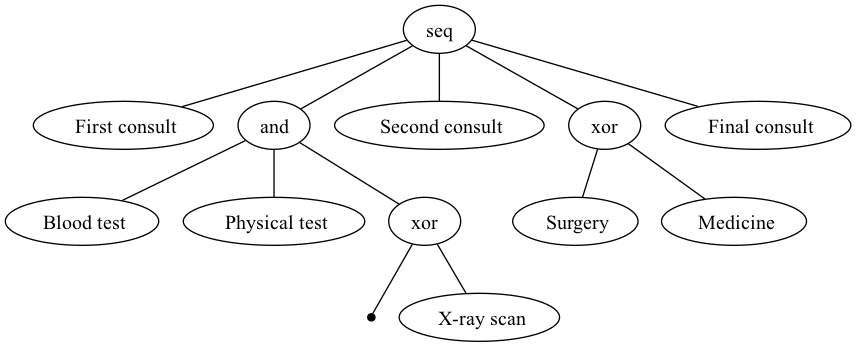

In [ ]:
# create the process tree
# (wvw: drop "_tree" from call)
tree = inductive_miner.apply(log)

# viz
gviz = pt_visualizer.apply(tree)
pt_visualizer.view(gviz)

Petri-net of inductive miner output

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

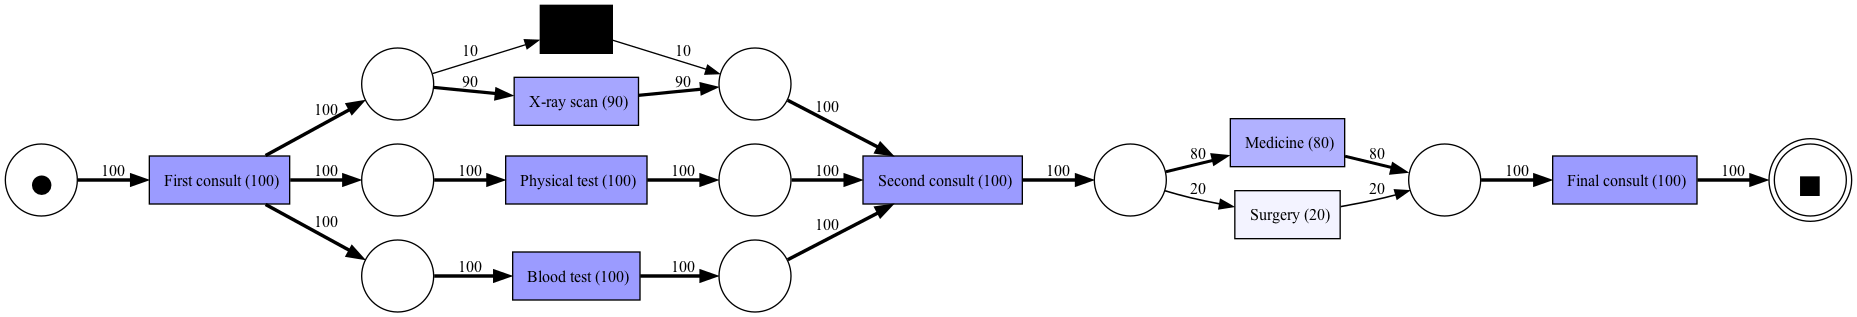

In [ ]:
# (wvw - only process tree mining seems to be supported currently)

# convert the process tree to a petri net
net, initial_marking, final_marking = pt_converter.apply(tree)


# (wvw: not working for me)
# alternatively, use the inductive_miner to create a petri net from scratch
# net, initial_marking, final_marking = inductive_miner.apply(log)

# viz
# parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                        #    parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)
pn_visualizer.view(gviz)

# pn_visualizer.save(gviz, "inductive_miner_healthcare_petri_net.png")

In [ ]:
#dir(net)

In [ ]:
from pm4py.visualization.petri_net.util import performance_map 
traces = performance_map.get_transition_performance_with_token_replay(log, net, initial_marking, final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# dir(traces)
traces

{"( First consult, ' First consult')": {'all_values': [0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  'case_association': {0: [0.0],
   95: [0.0],
   1: [0.0],
   10: [0.0],
   16: [0.0],
   45: [0.0],
   46: [0.0],
   67: [0.0],
   73: [0.0],
   

### Time between second consultation and surgery
* Mean in days
* Minimum in hours
* Maximum in days

dict_keys(["( First consult, ' First consult')", "( X-ray scan, ' X-ray scan')", "( Blood test, ' Blood test')", "( Physical test, ' Physical test')", "( Second consult, ' Second consult')", "( Medicine, ' Medicine')", "( Surgery, ' Surgery')", "( Final consult, ' Final consult')"])


**Mean time to surgery**: 4 days

**Max time to surgery**: 7 days

**Min time to surgery**: 0 days, i.e. 8 hours

**Min time to surgery**: 0 days, i.e. 8.469 hours

**Mean time to surgery**: 4 days, i.e. 94.247 hours

**Max time to surgery**: 7 days, i.e. 167.131 hours

<AxesSubplot:ylabel='Density'>

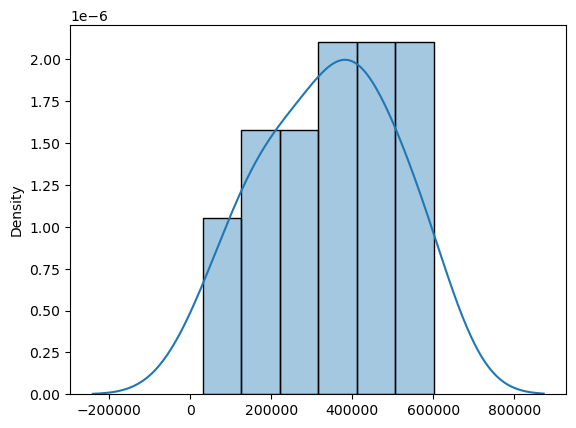

In [ ]:
# (wvw: use key from traces)
surgery_time = traces["( Surgery, ' Surgery')"]['all_values']
seconds_to_days = 60*60*24
seconds_to_hours = 60*60
printmd('**Mean time to surgery**: {:.0f} days'.format(np.mean(surgery_time)/seconds_to_days))
printmd('**Max time to surgery**: {:.0f} days'.format(np.max(surgery_time)/seconds_to_days))
printmd('**Min time to surgery**: {:.0f} days, i.e. {:.0f} hours'.format(np.min(surgery_time)/seconds_to_days, np.min(surgery_time)/seconds_to_hours))
printmd('**Min time to surgery**: {:.0f} days, i.e. {:.3f} hours'.format(np.min(surgery_time)/seconds_to_days, np.min(surgery_time)/seconds_to_hours))
printmd('**Mean time to surgery**: {:.0f} days, i.e. {:.3f} hours'.format(np.mean(surgery_time)/seconds_to_days, np.mean(surgery_time)/seconds_to_hours))
printmd('**Max time to surgery**: {:.0f} days, i.e. {:.3f} hours'.format(np.max(surgery_time)/seconds_to_days, np.max(surgery_time)/seconds_to_hours))
# (wvw: changed to histplot (deprecation warning) but leads to different results)
# sns.distplot(surgery_time)
sns.histplot(surgery_time, kde=True, stat="density", alpha=0.4, kde_kws={"cut": 3})

## Social Networks

* See [this guide](https://pm4py.fit.fraunhofer.de/documentation#social-network-analysis) on using pm4py to analyse social networks

In [ ]:
%matplotlib inline
# (wvw)
#!pip install pyvis
from pm4py.algo.organizational_mining.sna import algorithm as sna_algorithm
from pm4py.visualization.sna import visualizer as pn_vis

hw_values = sna_algorithm.apply(log, variant=sna_algorithm.Variants.HANDOVER_LOG)
#wt_values = sna_algorithm.apply(log, variant=sna_algorithm.Variants.WORKING_TOGETHER_LOG)
#sub_values = sna_algorithm.apply(log, variant=sna_algorithm.Variants.SUBCONTRACTING_LOG)
#ja_values = sna_algorithm.apply(log, variant=sna_algorithm.Variants.JOINTACTIVITIES_LOG)

gviz_hw = pn_vis.apply(hw_values, variant=pn_vis.Variants.PYVIS)
# gviz_wt = pn_vis.apply(wt_values, variant=pn_vis.Variants.NETWORKX,
#                        parameters={pn_vis.Variants.NETWORKX.value.Parameters.FORMAT: "png"})
# gviz_sub = pn_vis.apply(sub_values, variant=pn_vis.Variants.NETWORKX,
#                         parameters={pn_vis.Variants.NETWORKX.value.Parameters.FORMAT: "png"})
# gviz_ja = pn_vis.apply(ja_values, variant=pn_vis.Variants.PYVIS)

pn_vis.view(gviz_hw, variant=pn_vis.Variants.PYVIS)
# pn_vis.view(gviz_wt, variant=pn_vis.Variants.NETWORKX)
# pn_vis.view(gviz_sub, variant=pn_vis.Variants.NETWORKX)
# pn_vis.view(gviz_ja, variant=pn_vis.Variants.PYVIS)

In [ ]:
handover_nw